# LLM - Bielik - Fine tuning - part I

## Motivation

The rise and investments of the Large Language Models are definetely a game changer on various markets and branches - we can observe increased popularity of LLMs in academia, business and agriculture etc. Working with LLMs became a must-do task for all R&D or business departments in order to acknowledge and adapt upcoming possibilities, to stay competetive and gain business advantage. There are many players who invested bilions of USD to build their own Large Language Model and took a part in recent markets challenges by introducing their own solution trained on a different data set or to serve a different task (specialized for example in generation of poems or making a summary). At the beginning, as usual when it comes to innovation at that scale, we are thinking of endless possibilities, what kind of new opportunities we reach without putting much focus on other important factors like costs, maintanence, security, stability. Currently, we have multiple models which are production ready - many work has been done at those fields also making those LLMs more reliable and secured. One of the outcomes from this LLM race is that people noticed that it is good idea to look at smaller models, more specialized in one or two tasks, not the general ones. This specialization also is related to language supported. LLMs are broadly trained on english language data, due to the fact that more than half of websites content is written in English (source). Many models, paid and open source ones, have different level of quality when it comes when using them with local language. Quite often it occurs that offered quality is not enough to prove the business value for specific use case. This pushed some parties to create smaller models or suggested the finetuning with data in local language. 

The goal of this notebook is to finetune a Polish language based LLM called Bielik, developed by SpeakLeash organization (<model page>) with the legal / law sources. Data is specifically chosen for this task - legal documents or, law as a general concept, are strictly connected to the particular langauge. Primary concept of legal documents is to be in line with local (polish in my case) regulations. Of course, those documents can be translated to english and then used by the LLM. However, legal documents such as purchase agreements or any other agreements are designed by lawyers who understand the legal language nuances. They need to construct documents that are reliable, understandable by many (or maybe not?) and embedded in Polish law regulations. This requires from LLM to be more specific on many levels - starting from using prevalent data in one language and finetuning it to be able to work with more detailed task. 

## Introduction

This notebook covers multiple steps:
1. Loading and splitting data into chunks
2. Generating new data (question and answers) for the future finetuning
3. Evaluating generated data
4. Selecting the data based on metrics 
5. Preparing the output for FT


## Loading and splitting data

Data source: https://isap.sejm.gov.pl/isap.nsf/download.xsp/WDU20140000827/U/D20140827Lj.pdf 

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv
import pymupdf
import uuid
from pprint import pprint
from tqdm.notebook import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from src.external_requests.openai_req import OpenAIReq
from src.external_requests.prompting import PromptBuilder
from src.evaluation.distance_based import DistanceEvaluator
from src.preprocessing.preprocess import remove_stopwords, clean_text
from src.evaluation.reporting import Reporting
import seaborn as sns

In [2]:
_ = load_dotenv(find_dotenv())

In [3]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=120)

In [4]:
path = 'data/ustawa_nr_1.pdf'

all_data = pymupdf.open(path)

In [5]:
all_chunks = []
for document in all_data:
    text_page = document.get_textpage().extractText()
    chunks_per_page = splitter.split_text(text_page)
    all_chunks.append(chunks_per_page)
        
len(all_chunks)

44

In [6]:
all_chunks[43]

['©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n \n2024-01-18 \n \nZałącznik nr 2 \n \nWZÓR FORMULARZA ODSTĄPIENIA OD UMOWY \n \n(formularz ten należy wypełnić i odesłać tylko w przypadku chęci odstąpienia od umowy) \n– Adresat [w tym miejscu przedsiębiorca powinien wpisać nazwę przedsiębiorcy, pełny adres pocztowy oraz adres e-mail] \n– Ja/My(*) niniejszym informuję/informujemy(*) o moim/naszym odstąpieniu od umowy sprzedaży następujących  towarów(*)',
 '– Ja/My(*) niniejszym informuję/informujemy(*) o moim/naszym odstąpieniu od umowy sprzedaży następujących  towarów(*) \numowy dostawy następujących  towarów(*) umowy o dzieło polegającej na wykonaniu następujących towarów(*)/o \nświadczenie następującej usługi(*) \n– Data zawarcia umowy(*)/odbioru(*) \n– Imię i nazwisko konsumenta(-ów) \n– Adres konsumenta(-ów) \n– Podpis konsumenta(-ów) (tylko jeżeli formularz jest przesyłany w wersji papierowej) \n– Data \n \n \n \n \n(*) Niepotrzebne skreślić.']

## Generating new data (questions) with a support of GPT 3.5

In [7]:
all_data = []
for i, page in tqdm(enumerate(all_chunks)):
    page_id = str(uuid.uuid4())
    for chunk in enumerate(page):
        nth_chunk, text_chunk = chunk
        generated_questions = OpenAIReq().call_api(prompt=PromptBuilder.generate_questions(n_questions=3, text=chunk), 
                                                   max_tokens=400,
                                                   temperature=0.2)
        data = {'chunk_id': f'{page_id}_{nth_chunk}', 
                'text_chunk': text_chunk,
                'page_id': page_id,
                'generated_questions': generated_questions}
        all_data.append(data)

0it [00:00, ?it/s]

In [8]:
df = pd.DataFrame.from_dict(data=all_data)
df

,chunk_id,text_chunk,page_id,generated_questions
0,184fe94e-5c92-4c01-8b86-d915015a24e8_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,184fe94e-5c92-4c01-8b86-d915015a24e8,- Jakie prawa określa ustawa z dnia 30 maja 20...
1,184fe94e-5c92-4c01-8b86-d915015a24e8_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,184fe94e-5c92-4c01-8b86-d915015a24e8,- Jakie są główne zasady i tryby wykonania pra...
2,184fe94e-5c92-4c01-8b86-d915015a24e8_2,1) dyrektywę Parlamentu Europejskiego i Rady 2...,184fe94e-5c92-4c01-8b86-d915015a24e8,- Jakie konkretnie prawa konsumentów reguluje ...
3,184fe94e-5c92-4c01-8b86-d915015a24e8_3,2019/2161 z dnia 27 listopada 2019 r. (Dz. Urz...,184fe94e-5c92-4c01-8b86-d915015a24e8,- Jakie zmiany wprowadza dyrektywa 2019/2161 z...
4,184fe94e-5c92-4c01-8b86-d915015a24e8_4,"z późn. zm.), ostatnio zmienioną dyrektywą Par...",184fe94e-5c92-4c01-8b86-d915015a24e8,- Jakie zmiany wprowadziła dyrektywa Parlament...
...,...,...,...,...
251,7382fdd7-d647-4ef2-b8c2-96d94dbe2c99_7,zawarcia umowy: „Odbioru towaru dokonamy na na...,7382fdd7-d647-4ef2-b8c2-96d94dbe2c99,"- Czy zapis ""Odbioru towaru dokonamy na nasz k..."
252,7382fdd7-d647-4ef2-b8c2-96d94dbe2c99_8,[6] W przypadku umów dotyczących świadczenia u...,7382fdd7-d647-4ef2-b8c2-96d94dbe2c99,- Czy w przypadku umów dotyczących świadczenia...
253,7382fdd7-d647-4ef2-b8c2-96d94dbe2c99_9,cieplnej [niepotrzebne skreślić] przed upływem...,7382fdd7-d647-4ef2-b8c2-96d94dbe2c99,- Jakie są konsekwencje odstąpienia od umowy p...
254,d21653c8-2209-4f48-9032-77e336c59068_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,d21653c8-2209-4f48-9032-77e336c59068,- Czy formularz odstąpienia od umowy musi być ...


In [9]:
# Saving checkpoint
df.to_excel('data/01_questions_and_chunks.xlsx')

In [10]:
df = pd.read_excel('data/01_questions_and_chunks.xlsx', index_col=0)

In [11]:
def process_df_with_questions(data: pd.DataFrame) -> pd.DataFrame:
    data['generated_questions_array'] = data['generated_questions'].str.split('\n')
    data = data.explode('generated_questions_array')
    data = data[~data['generated_questions_array'].isna()]
    data['generated_questions_array']  = data['generated_questions_array'].replace(r'^\s*$', np.nan, regex=True)
    return data

df = process_df_with_questions(data=df)

In [18]:
df = df[~df['generated_questions_array'].isna()]
df['generated_questions_array'].isna().sum()

0

In [22]:
df.shape

(768, 5)

### Fetching answer for generated question based on chunk

In [24]:
df['answer'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_answers_based_on_text_and_questions(text=x['text_chunk'], question= x['generated_questions_array'])), axis=1)

/tmp/ipykernel_5150/1586777845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['answer'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_answers_based_on_text_and_questions(text=x['text_chunk'], question= x['generated_questions_array'])), axis=1)


In [25]:
df.to_excel('data/02_data_with_answers.xlsx')

### Verifing the quality of generated answers and questions based on selected metrics

#### Selected metrics
- Coverage 
- Coherence (Consistency)
- Word Mover Distance 
- Relevance
- Global relevance

In [26]:
df['coverage_rating'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coverage(question=x['generated_questions_array'], context=x['text_chunk'])), axis=1)

/tmp/ipykernel_5150/3657337170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coverage_rating'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coverage(question=x['generated_questions_array'], context=x['text_chunk'])), axis=1)


<Axes: >

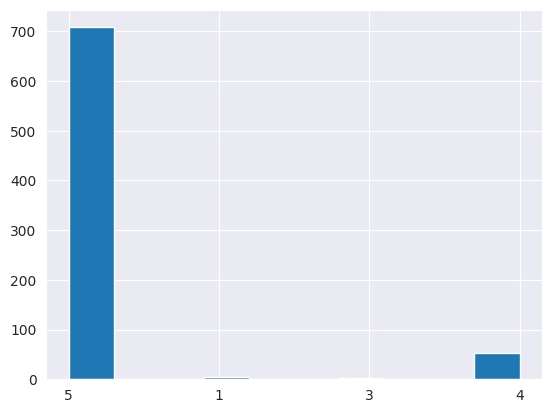

In [27]:
pd.plotting.hist_series(df['coverage_rating'])

In [28]:
df.to_excel('data/03_data_with_answers_and_cov.xlsx')

In [29]:
df['text_wo_stopwords'] = df['text_chunk'].apply(remove_stopwords)

/tmp/ipykernel_5150/4248919023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_wo_stopwords'] = df['text_chunk'].apply(remove_stopwords)


In [30]:
df['question_wo_stopwords'] = df['generated_questions_array'].apply(remove_stopwords)

/tmp/ipykernel_5150/1528545863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['question_wo_stopwords'] = df['generated_questions_array'].apply(remove_stopwords)


In [31]:
df.to_excel('data/04_data_without_stopwords.xlsx')

In [32]:
df = pd.read_excel('data/data_without_stopdwords.xlsx', index_col=0)

In [33]:
df['chunk'] = df['text_chunk'].apply(lambda x: clean_text(x))

In [34]:
dist_evaluator = DistanceEvaluator()
df['wmd_question_answer'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['generated_questions_array'], x['answer']), axis=1)

<Axes: >

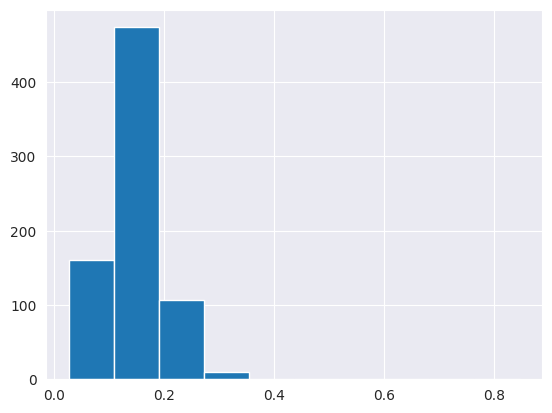

In [35]:
pd.plotting.hist_series(df['wmd_question_answer'])

In [37]:
df['wmd_chunk_question'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['text_chunk'], x['generated_questions_array']), axis=1)

<Axes: >

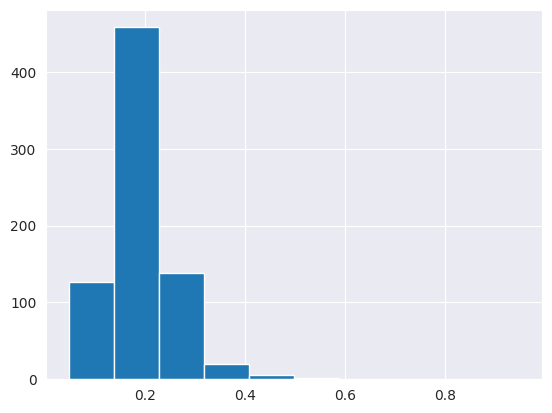

In [38]:
pd.plotting.hist_series(df['wmd_chunk_question'])

In [63]:
sample_df = df.sample(3)

In [39]:
df['coherence'] = df['generated_questions_array'].apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coherence(x)))

In [40]:
df.to_excel('data/05_data_with_coherence.xlsx')

In [42]:
df = pd.read_excel('data/05_data_with_coherence.xlsx', index_col=0)

In [43]:
df.columns

Index(['chunk_id', 'text_chunk', 'page_id', 'generated_questions',
       'generated_questions_array', 'answer', 'coverage_rating',
       'coverage_rating_no_answer', 'text_wo_stopwords',
       'question_wo_stopwords', 'chunk', 'wmd_question_answer',
       'wmd_chunk_question', 'coherence'],
      dtype='object')

In [44]:
df[['coherence_rate', 'coherence_expl']] = df.coherence.str.split(',', n=1,  expand=True)

In [45]:
df['coherence_rate'] = df.coherence_rate.str.replace('(', '')
df['coherence_expl'] = df.coherence_expl.str.replace(')', '')
df['coherence_expl'] = df.coherence_expl.str.replace('"', '')
df

,chunk_id,text_chunk,page_id,generated_questions,generated_questions_array,answer,coverage_rating,coverage_rating_no_answer,text_wo_stopwords,question_wo_stopwords,chunk,wmd_question_answer,wmd_chunk_question,coherence,coherence_rate,coherence_expl
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie prawa określa ustawa z dnia 30 maja 20...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...,5,5,"['©kancelaria', 'sejmu', 's.', '1/44', '2024-0...","['-', 'prawa', 'określa', 'ustawa', 'dnia', '3...",©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.341273,0.301395,"(3, ""The question is coherent in terms of aski...",3,The question is coherent in terms of asking a...
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie obowiązki ma przedsiębiorca zawierając...,"Zgodnie z art. 1 ustawy o prawach konsumenta, ...",5,5,"['©kancelaria', 'sejmu', 's.', '1/44', '2024-0...","['-', 'obowiązki', 'przedsiębiorca', 'zawieraj...",©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.139826,0.209397,"(3, The question is coherent in terms of askin...",3,The question is coherent in terms of asking a...
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- W jaki sposób regulowane są zasady i tryb za...,Zasady i tryb zawierania umowy na odległość i ...,5,5,"['©kancelaria', 'sejmu', 's.', '1/44', '2024-0...","['-', 'regulowane', 'zasady', 'tryb', 'zawiera...",©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.122686,0.216716,"(4, ""The question is coherent and fluent, but ...",4,"The question is coherent and fluent, but coul..."
1,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są zasady i tryb wykonania prawa odstą...,- Jakie są zasady i tryb wykonania prawa odstą...,Zasady i tryb wykonania prawa odstąpienia od u...,5,5,"['przedsiębiorstwa;', '3)', 'zasady', 'tryb', ...","['-', 'zasady', 'tryb', 'wykonania', 'prawa', ...",przedsiębiorstwa; 3) zasady i tryb wykonania p...,0.112443,0.153880,"(3, The question is coherent in terms of addre...",3,The question is coherent in terms of addressi...
1,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są zasady i tryb wykonania prawa odstą...,- W jaki sposób regulacje dotyczące umowy na o...,Umowa na odległość dotycząca usług finansowych...,5,5,"['przedsiębiorstwa;', '3)', 'zasady', 'tryb', ...","['-', 'regulacje', 'dotyczące', 'umowy', 'odle...",przedsiębiorstwa; 3) zasady i tryb wykonania p...,0.264828,0.284043,"(4, ""The question is coherent and clear, askin...",4,"The question is coherent and clear, asking ab..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...,"- Jakie są konsekwencje prawne dla konsumenta,...",Jeśli konsument nie zastosuje się do procedury...,5,5,"['©kancelaria', 'sejmu', 's.', '44/44', '2024-...","['-', 'konsekwencje', 'prawne', 'konsumenta,',...",©Kancelaria Sejmu s. 44/44 2024-01-18 Z...,0.137973,0.232825,"(4, ""The question is clear and coherent, but c...",4,"The question is clear and coherent, but could..."
249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...,"- Czy istnieją okoliczności, w których odstąpi...","Tak, istnieją okoliczności, w których odstąpie...",5,5,"['©kancelaria', 'sejmu', 's.', '44/44', '2024-...","['-', 'istnieją

In [46]:
df.to_excel('data/06_latest.xlsx', index = False)

In [47]:
df = pd.read_excel('data/06_latest.xlsx')

In [48]:
df.columns

Index(['chunk_id', 'text_chunk', 'page_id', 'generated_questions',
       'generated_questions_array', 'answer', 'coverage_rating',
       'coverage_rating_no_answer', 'text_wo_stopwords',
       'question_wo_stopwords', 'chunk', 'wmd_question_answer',
       'wmd_chunk_question', 'coherence', 'coherence_rate', 'coherence_expl'],
      dtype='object')

In [6]:
sample_df = df.sample(15)

In [49]:
df[['text_chunk', 'chunk']]

,text_chunk,chunk
0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,©Kancelaria Sejmu s. 1/44 2024-01-18 D...
1,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,©Kancelaria Sejmu s. 1/44 2024-01-18 D...
2,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,©Kancelaria Sejmu s. 1/44 2024-01-18 D...
3,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,przedsiębiorstwa; 3) zasady i tryb wykonania p...
4,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,przedsiębiorstwa; 3) zasady i tryb wykonania p...
...,...,...
748,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,©Kancelaria Sejmu s. 44/44 2024-01-18 Z...
749,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,©Kancelaria Sejmu s. 44/44 2024-01-18 Z...
750,umowy dostawy następujących towarów(*) umowy ...,umowy dostawy następujących towarów(*) umowy ...
751,umowy dostawy następujących towarów(*) umowy ...,umowy dostawy następujących towarów(*) umowy ...


In [50]:
df['relevance'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_relevance(question=x['generated_questions_array'], context=x['text_chunk'])),axis=1)

In [51]:
df['global_relevance'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_global_relevance(question=x['generated_questions_array'])),axis=1)

In [52]:
df['relevance'].value_counts(normalize=True)

relevance
5    0.989376
1    0.006640
4    0.002656
3    0.001328
Name: proportion, dtype: float64

In [53]:
df['global_relevance'].value_counts(normalize=True)

global_relevance
5    0.989376
1    0.006640
3    0.002656
2    0.001328
Name: proportion, dtype: float64

In [54]:
df.to_excel('data/07_data_with_relevances.xlsx')

## Evaluation

In [55]:
reporting = Reporting(data=df)
sim_matrix = reporting.create_similarity_matrix_for_wmd(on_column='generated_questions_array')

753it [07:43,  1.62it/s]


In [56]:
sim_matrix.shape

(752, 752)

### Plotting the results of similarity matrix

In [57]:
if sim_matrix.shape[0] < 30: #plot only when sampled
    mask = np.zeros_like(sim_matrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(sim_matrix,
                annot=True,
                fmt='.2f',
                linewidth=.5,
                cmap='crest',
                mask=mask,
                annot_kws={'fontsize': 8})

### Evaluation Summary

#### Relevance anf global relevance

In [14]:
df['relevance'].value_counts(normalize=True)

relevance
5    0.989376
1    0.003984
4    0.003984
3    0.002656
Name: proportion, dtype: float64

<Axes: >

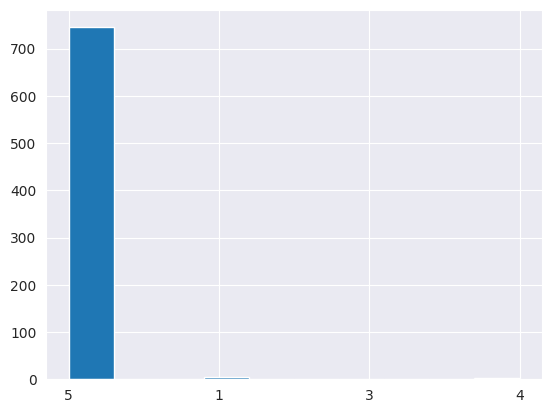

In [58]:
pd.plotting.hist_series(df['relevance'])

In [59]:
df['global_relevance'].value_counts(normalize=True)

global_relevance
5    0.989376
1    0.006640
3    0.002656
2    0.001328
Name: proportion, dtype: float64

<Axes: >

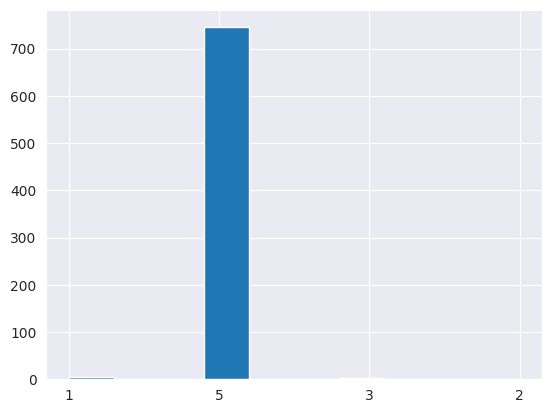

In [60]:
pd.plotting.hist_series(df['global_relevance'])

#### Coverage summary

In [61]:
df['coverage_rating'].value_counts(normalize=True)

coverage_rating
5    1.0
Name: proportion, dtype: float64

<Axes: >

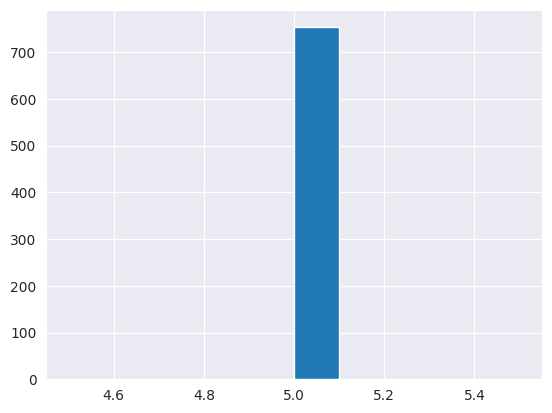

In [24]:
pd.plotting.hist_series(df['coverage_rating'])

In [62]:
df['coverage_rating_no_answer'].value_counts(normalize=True)

coverage_rating_no_answer
5    0.938911
4    0.049137
1    0.007968
2    0.002656
3    0.001328
Name: proportion, dtype: float64

<Axes: >

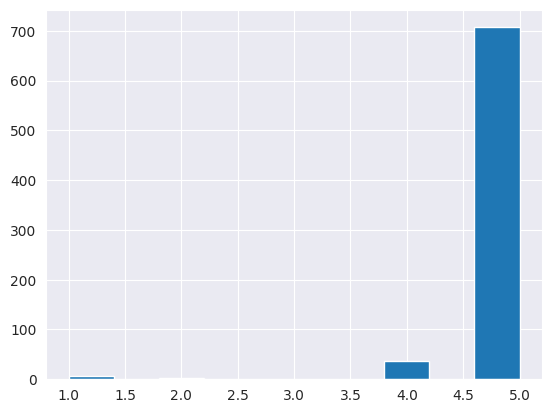

In [63]:
pd.plotting.hist_series(df['coverage_rating_no_answer'])

#### Word mover distance

In [64]:
# WMD question <-> chunk
pd.plotting.hist_series(df['wmd'])

KeyError: 'wmd'

In [28]:
mean_wmd_qch = df['wmd'].mean()
std_wmd_qch = df['wmd'].std()
print(f'Mean for question to chunk for WMD is {mean_wmd_qch} with std as {std_wmd_qch}')

Mean for question to chunk for WMD is 0.19339181580439138 with std as 0.07003015277804153


<Axes: >

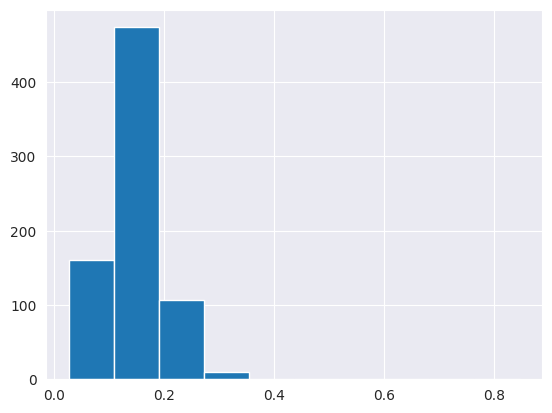

In [29]:
# WMD question <-> answer
pd.plotting.hist_series(df['wmd_question_answer'])

In [65]:
mean_wmd_qa = df['wmd_question_answer'].mean()
std_wmd_qa = df['wmd_question_answer'].std()
print(f'Mean for question to answer for WMD is {mean_wmd_qa} with std as {std_wmd_qa}')

Mean for question to answer for WMD is 0.14663981538771198 with std as 0.05362387325462629


In [66]:
# WMD question <-> question
std, mean = reporting.get_summary_for_wmd(sim_matrix)
print(f'Mean for question to question for WMD is {mean} with std as {std}')

Mean for question to question for WMD is 0.2407836529716644 with std as 0.06884521720370682


#### Coherence rate

In [67]:
df['coherence_rate'].value_counts(normalize=True)

coherence_rate
4                                                                                                                                                                                                                    0.438247
3                                                                                                                                                                                                                    0.394422
2                                                                                                                                                                                                                    0.155378
2 | The question is somewhat coherent as it asks about situations where an unplanned visit by a businessperson to a consumer could result in the formation of a valid contract according to the law. However         0.001328
3 | The question is coherent in terms of addressing a specific legal issue regarding the priority

#### Evaluation Summary
From the provided results we can observe that in majority of cases generated question are quite fluent (86.5% got score 3 and 4 combined).
Coverage metric (if answer can be reliable extracted from question and context) is also high. This point is to be investigated as it was based on LLM verification.
Relevances ratings are also high meaning that generated questions preserve high quality and resemblance to ones asked by professionals.
Word's Mover Distance (Diversity) with mean scores 0.19, 0.14 and 0.24 for question to chunk, question to answer and question to question respectively, show that generated questions have small distance which means that they show small diversity and are consistent with each other. 

### Data preparation for FT

In [68]:
qa_df = df[['generated_questions_array', 'answer']]

In [69]:
qa_df = qa_df.rename(columns={'generated_questions_array': 'question'})

In [70]:
with open('data/input_data_ft_400.jsonl', "w") as f:
    f.write(qa_df.to_json(orient='records', lines=True, force_ascii=False))